In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)
#source('tests.R')
#source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Prediction to the risk of heart attack 

### INTRODUCTION
Heart attack happens when a part of the heart muscle doesn’t get enough blood. Nowadays, heart attack is a common and deadly disease across the world. In a year, millions of people suffer from heart attacks that mostly result in death. As a result, more and more people are paying attention to this matter. Therefore, if we can predict someone with a high risk of heart attack beforehand, it may save his/her life by taking some quick medical treatment and changing their lifestyle! 

In this project, we are trying to predict whether someone has a high risk of getting a heart attack or not. We will analyze numerous data in a dataset with various factors that may influence the risks of getting heart attack. The Hungarian heart attack data is imported from UCI machine learning repository, written in .tsv format, containing 294 rows and 14 columns. One of the variables, which is “num”, is what we are trying to predict. The values of the “num” column are either 1 (high risk) or 0 (low risk).

### Preliminary exploratory data analysis

##### Reading and tidying the data

In [2]:
heart_attack_data_raw = read_delim("https://raw.githubusercontent.com/RichardAdhika22/group115/main/processed.hungarian%20(1).data",delim=","
                                ,col_names=FALSE)
colnames(heart_attack_data_raw) = c('age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num')
heart_attack_data_tidy = select(heart_attack_data_raw,-slope,-ca,-thal)
heart_attack_data_tidy = filter_all(heart_attack_data_tidy,all_vars(.!="?"))
heart_attack_data_tidy = mutate_if(heart_attack_data_tidy, is.character,as.numeric) |> mutate(num = as.factor(num))

heart_attack_data_tidy


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,1,2,130,132,0,2,185,0,0,0
29,1,2,120,243,0,0,160,0,0,0
30,0,1,170,237,0,1,170,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,1
58,0,2,180,393,0,0,110,1,1,1
65,1,4,130,275,0,1,115,1,1,1


##### Splitting the data into training and testing data

In [3]:
heart_attack_split = initial_split(heart_attack_data_tidy, prop = 0.75, strata = num)
heart_attack_training = training(heart_attack_split)
heart_attack_testing = testing(heart_attack_split)

In [4]:
heart_attack_data_selected = heart_attack_training |>
    select(age,sex,trestbps,chol,thalach,oldpeak,num)

heart_attack_data_selected

age,sex,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,1,130,132,185,0,0
29,1,120,243,160,0,0
30,0,170,237,170,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
54,0,130,294,100,0,1
56,1,155,342,150,3,1
65,1,130,275,115,1,1


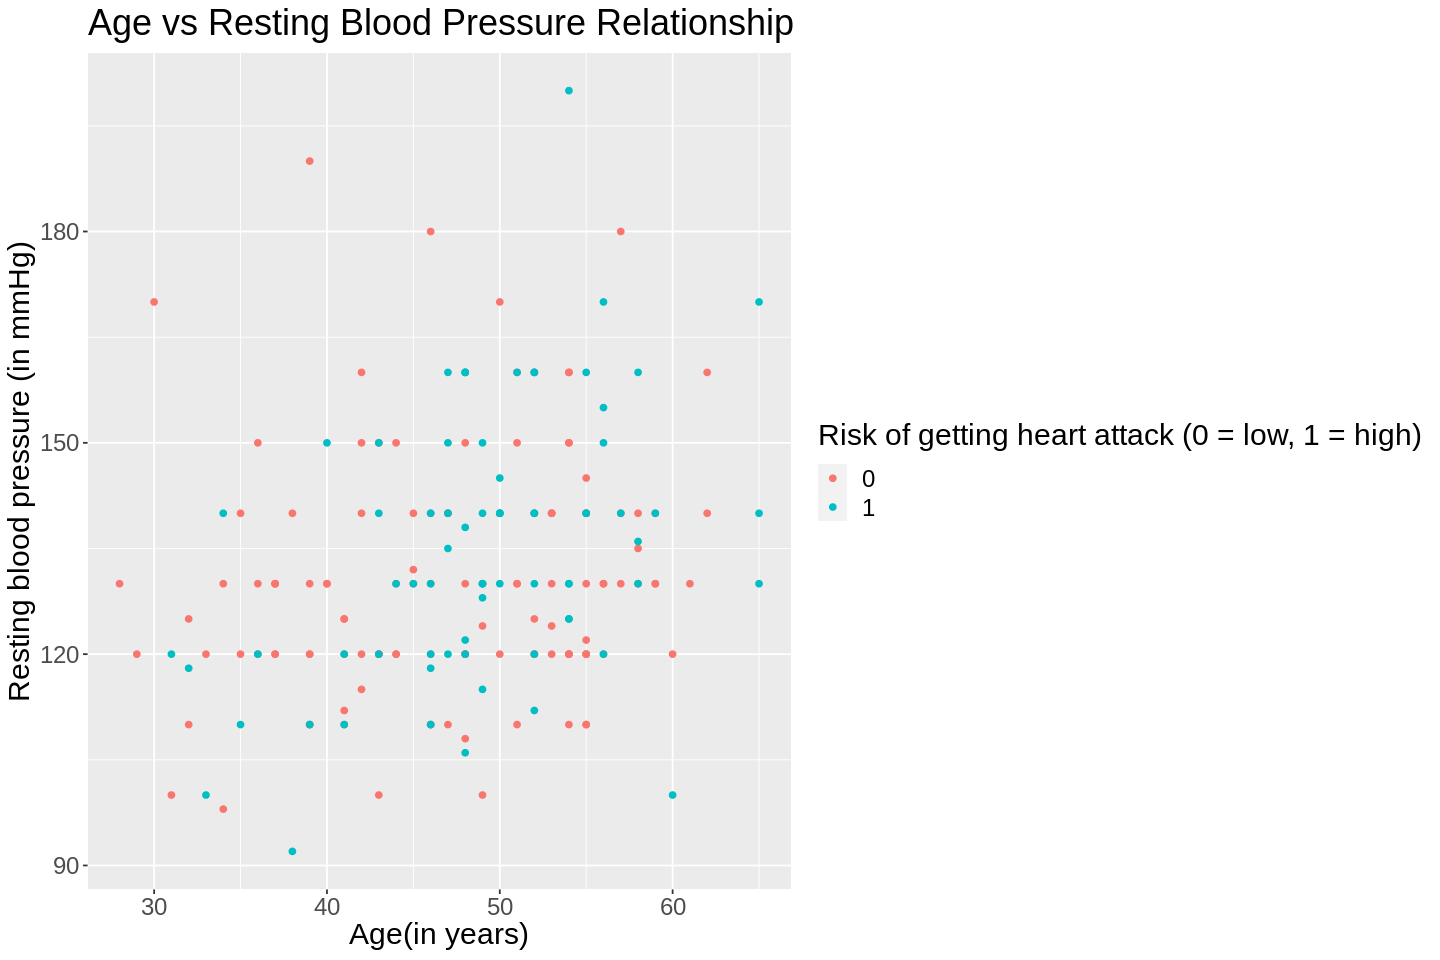

In [5]:
options(repr.plot.width=12, repr.plot.height=8)

age_vs_trestbps = ggplot(heart_attack_data_selected,aes(x=age,y=trestbps,color=num))+
    geom_point() +
    labs(x = "Age(in years)",y = "Resting blood pressure (in mmHg)", color = "Risk of getting heart attack (0 = low, 1 = high)")+
    ggtitle("Age vs Resting Blood Pressure Relationship")+
    theme(text = element_text(size=18))

age_vs_trestbps

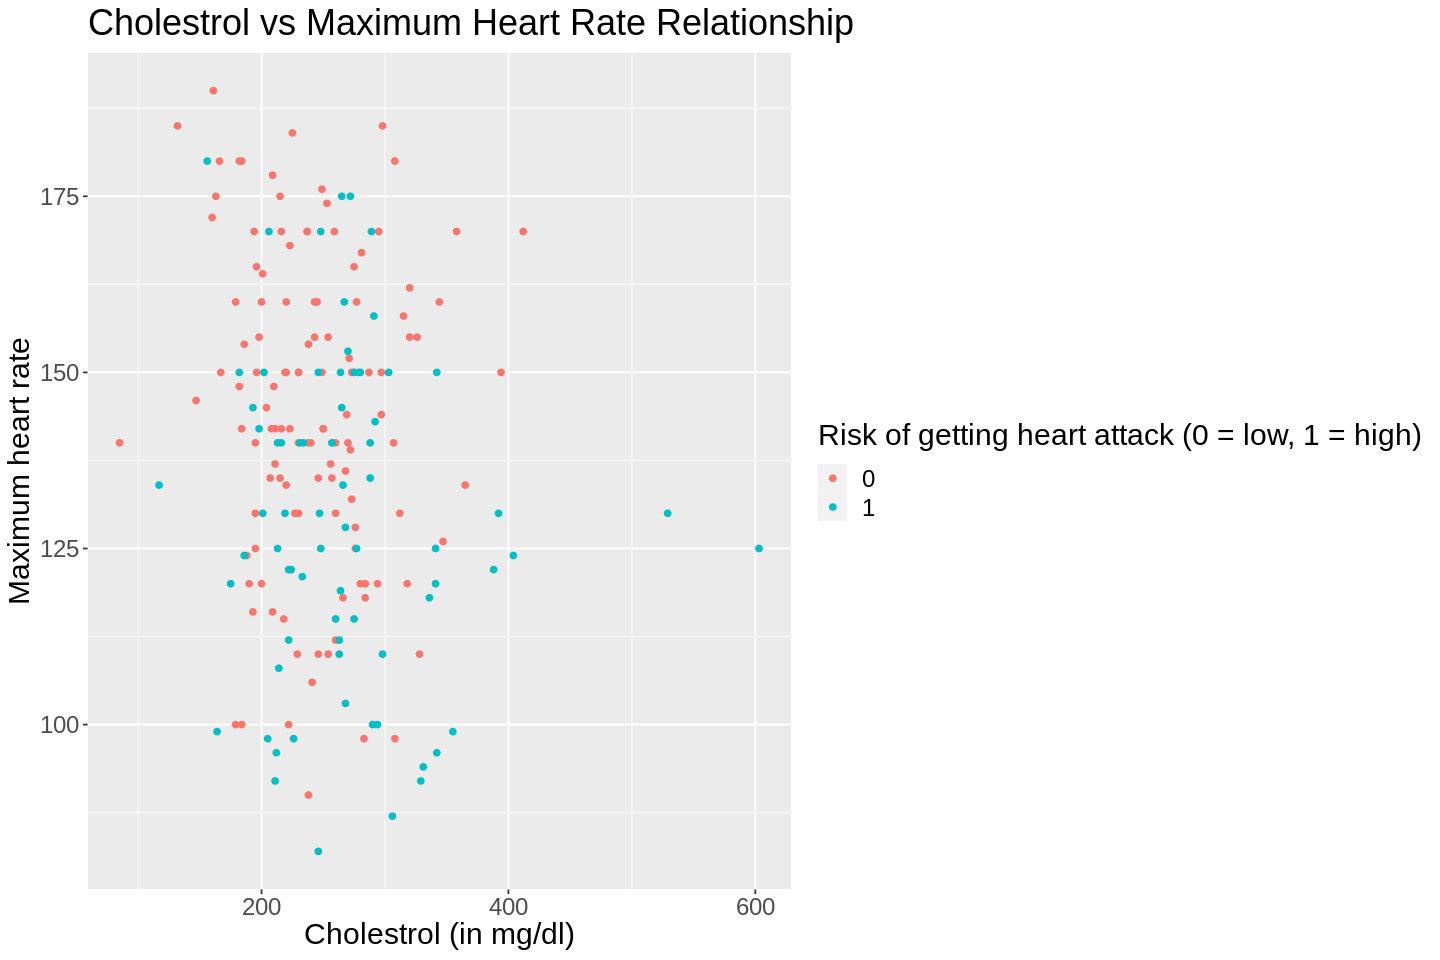

In [6]:
chol_vs_thalach = ggplot(heart_attack_data_selected,aes(x = chol,y = thalach,color=num))+
    geom_point() +
    labs(x = "Cholestrol (in mg/dl)",y = "Maximum heart rate", color = "Risk of getting heart attack (0 = low, 1 = high)")+
    ggtitle("Cholestrol vs Maximum Heart Rate Relationship")+
    theme(text = element_text(size=18))

chol_vs_thalach

##### Average of each predictor variables

In [7]:
table_means = select(heart_attack_data_selected,-sex) |>
    group_by(num) |>
    summarize(across(age:oldpeak,mean))

colnames(table_means) = c('num',"mean_age","mean_terstbps","mean_chol","mean_thalach","mean_oldpeak")
table_means

num,mean_age,mean_terstbps,mean_chol,mean_thalach,mean_oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,47.09016,130.2049,242.6967,144.2869,0.2155738
1,49.06849,134.9315,268.2192,128.9315,1.3082192


##### Amount of each class

In [8]:
total_amount = heart_attack_data_selected |>
    summarize("total"=n())|>
    pull()

table_num_count = heart_attack_data_selected |>
    group_by(num) |>
    summarize("total_number_of_num" = n())|>
    mutate("percentage" = total_number_of_num/total_amount*100)

table_num_count 

num,total_number_of_num,percentage
<fct>,<int>,<dbl>
0,122,62.5641
1,73,37.4359


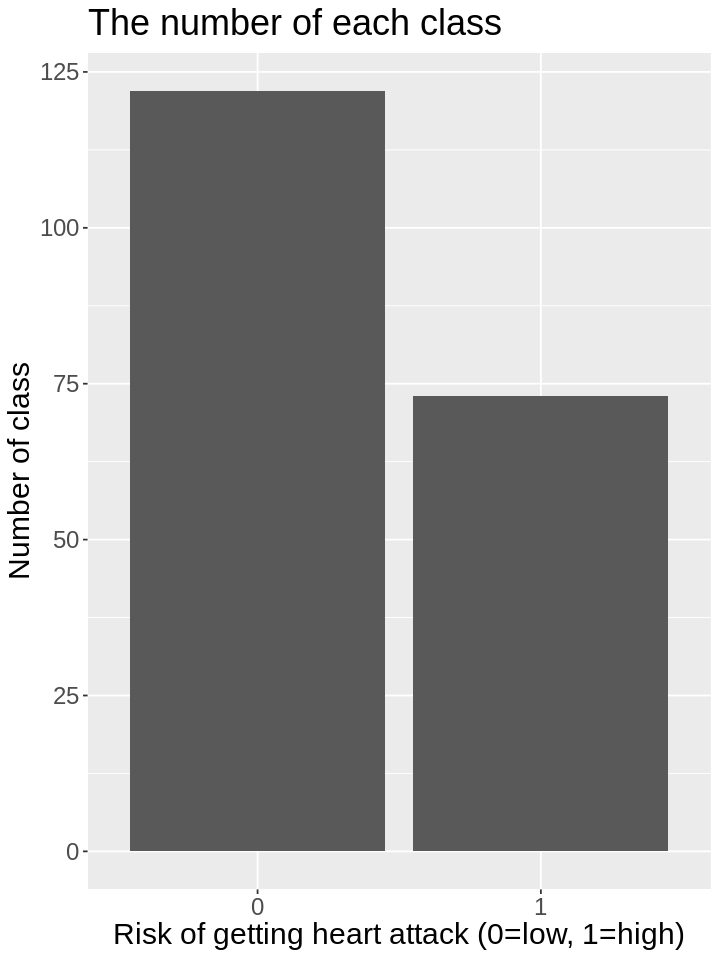

In [9]:
options(repr.plot.width=6, repr.plot.height=8)

num_count_plot = table_num_count |>
    ggplot(aes(x = num, y = total_number_of_num))+
    geom_bar(stat="identity")+
    labs(x = "Risk of getting heart attack (0=low, 1=high)", y = "Number of class")+
    ggtitle("The number of each class")+
    theme(text = element_text(size=18))

num_count_plot

### The number of omitted observations

In [10]:
missing_data = nrow(heart_attack_data_raw) - nrow(heart_attack_data_tidy)
missing_data

[1] 33

In [11]:
value_count = pull(table_num_count, total_number_of_num)

summary_table = bind_cols(table_means,value_count)
    colnames(summary_table) = c('num',"mean_age","mean_terstbps","mean_chol","mean_thalach","mean_oldpeak","total_number_of_num")
summary_table

New names:
• `` -> `...7`


num,mean_age,mean_terstbps,mean_chol,mean_thalach,mean_oldpeak,total_number_of_num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,47.09016,130.2049,242.6967,144.2869,0.2155738,122
1,49.06849,134.9315,268.2192,128.9315,1.3082192,73


### Distributions

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



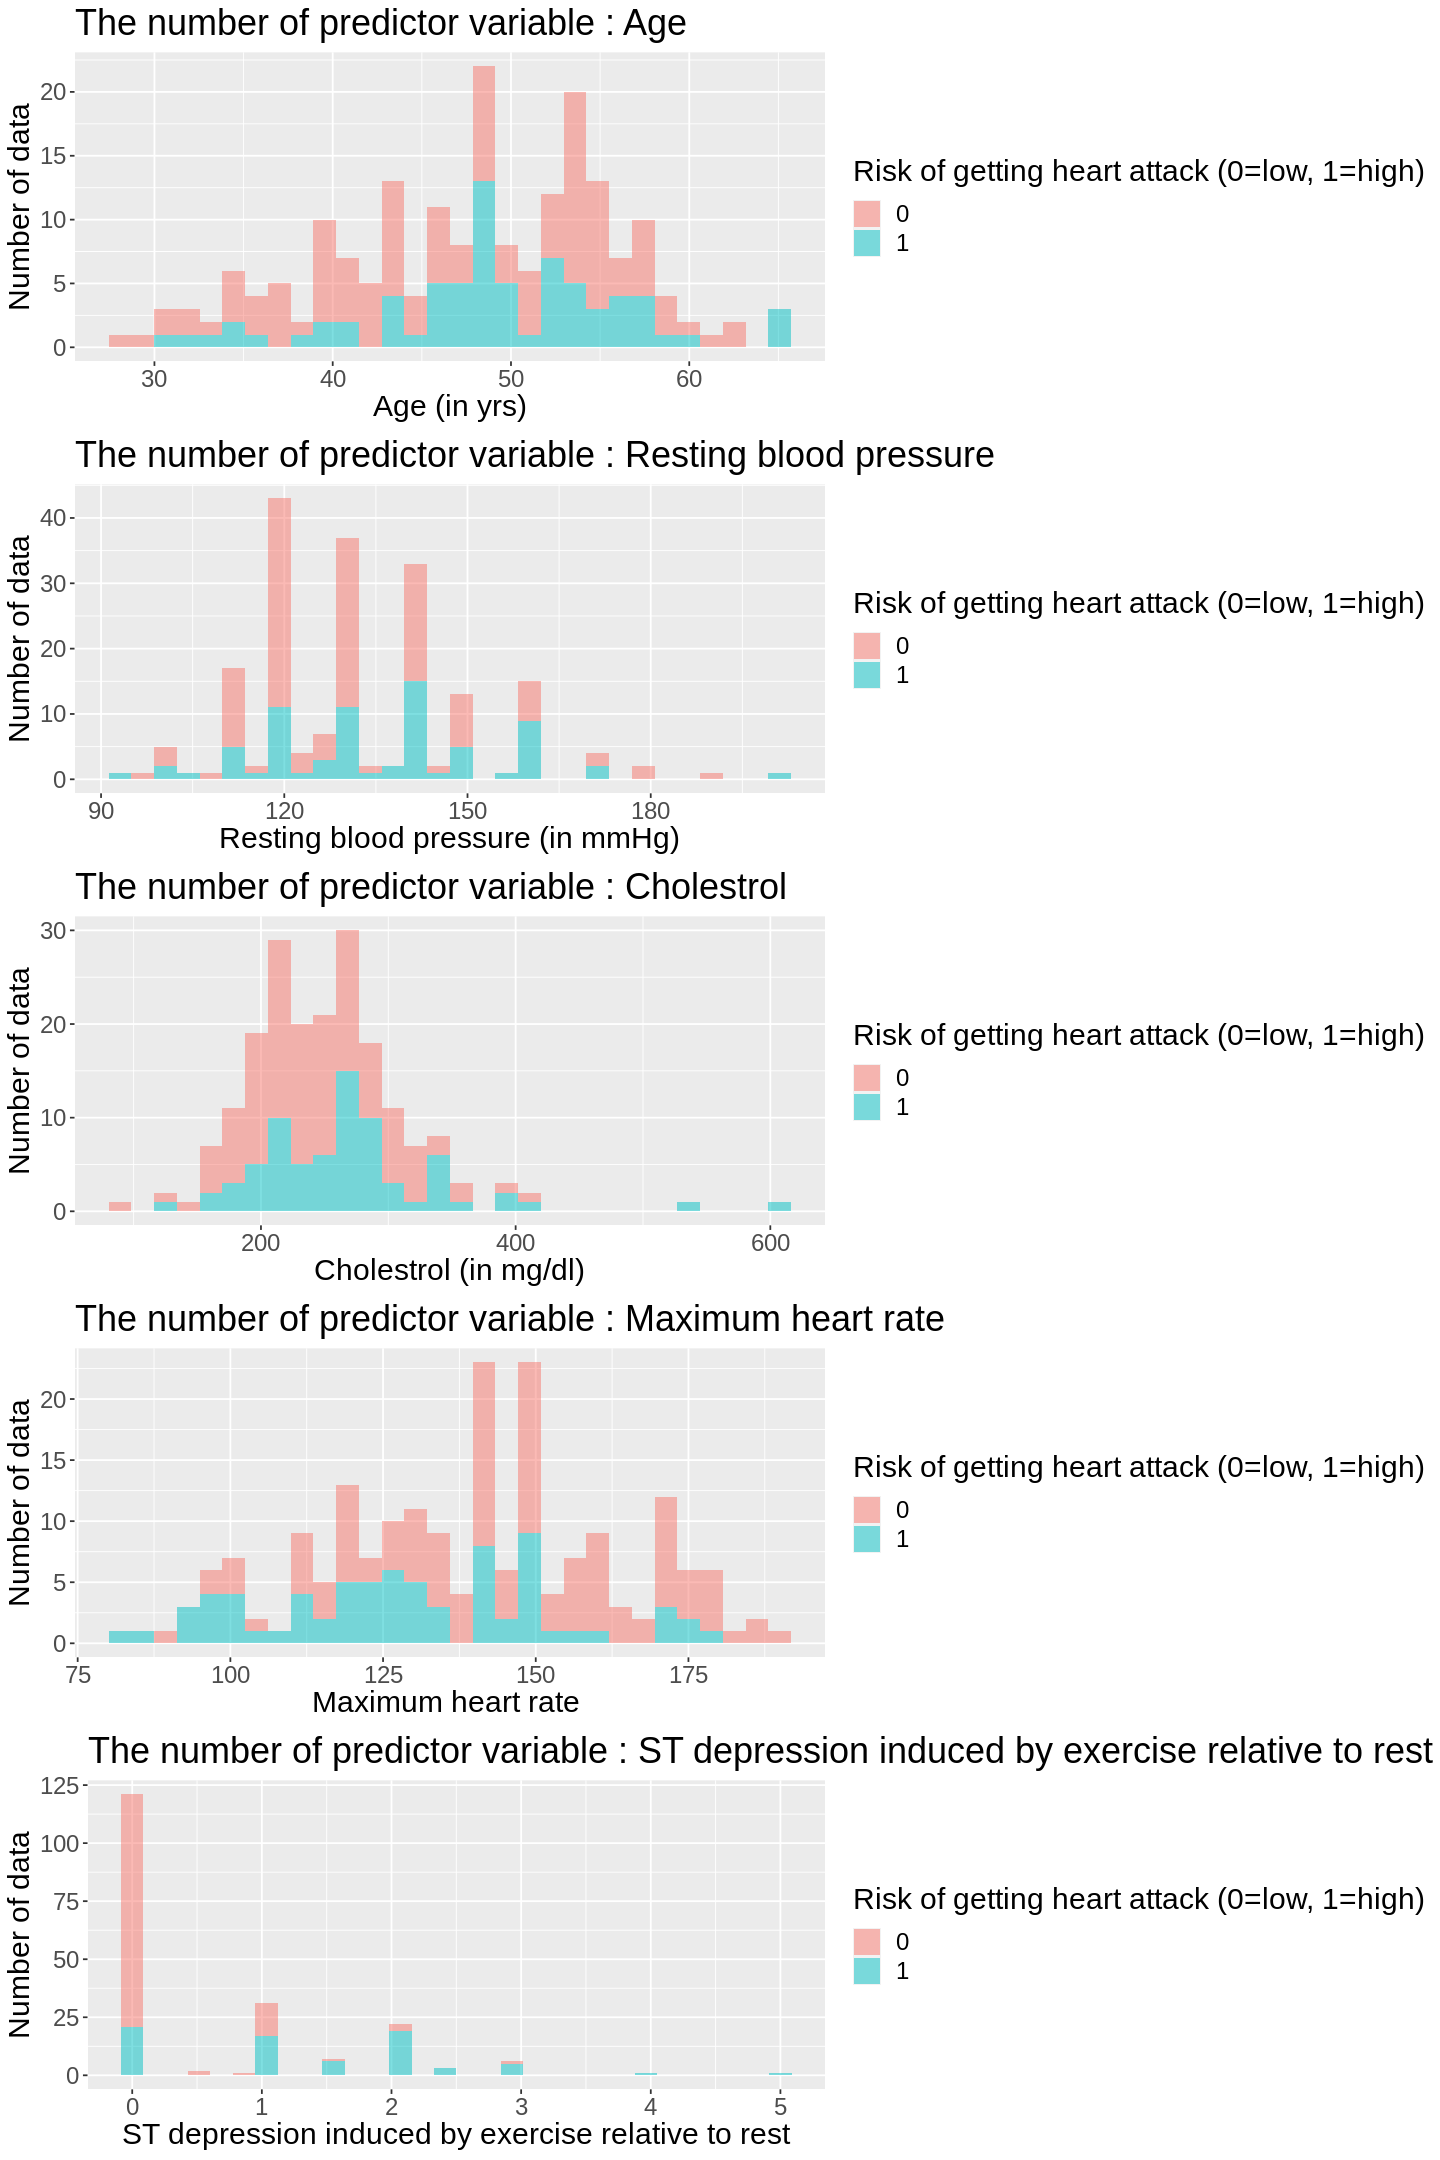

In [12]:
# age_hist = hist(raw_age,main="Histogram of age distribution",xlab="Age",ylab="Frequency")
# trestbps_hist = hist(raw_trestbps,main="Histogram of trestbps distribution",xlab="Age",ylab="Frequency")
# chol_hist = hist(raw_chol,main="Histogram of chol distribution",xlab="Age",ylab="Frequency")
# thalach_hist = hist(raw_thalach,main="Histogram of thalach distribution",xlab="Age",ylab="Frequency")
# oldpeak_hist = hist(raw_oldpeak,main="Histogram of oldpeak distribution",xlab="Age",ylab="Frequency")

options(repr.plot.width=12, repr.plot.height=18)

age_hist = heart_attack_data_selected |>
    ggplot(aes(x=age, fill=num))+
    geom_histogram(alpha=0.5)+
    labs(x = "Age (in yrs)", y = "Number of data", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("The number of predictor variable : Age")+
    theme(text = element_text(size=18))

trestbps_hist = heart_attack_data_selected |>
    ggplot(aes(x=trestbps, fill=num))+
    geom_histogram(alpha=0.5)+
    labs(x = "Resting blood pressure (in mmHg)", y = "Number of data", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("The number of predictor variable : Resting blood pressure")+
    theme(text = element_text(size=18))

chol_hist = heart_attack_data_selected |>
    ggplot(aes(x=chol, fill=num))+
    geom_histogram(alpha=0.5)+
    labs(x = "Cholestrol (in mg/dl)", y = "Number of data", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("The number of predictor variable : Cholestrol")+
    theme(text = element_text(size=18))

thalach_hist = heart_attack_data_selected |>
    ggplot(aes(x=thalach, fill=num))+
    geom_histogram(alpha=0.5)+
    labs(x = "Maximum heart rate ", y = "Number of data", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("The number of predictor variable : Maximum heart rate")+
    theme(text = element_text(size=18))

oldpeak_hist = heart_attack_data_selected |>
    ggplot(aes(x=oldpeak, fill=num))+
    geom_histogram(alpha=0.5)+
    labs(x = "ST depression induced by exercise relative to rest", y = "Number of data", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("The number of predictor variable : ST depression induced by exercise relative to rest")+
    theme(text = element_text(size=18))

plot_grid(age_hist, trestbps_hist, chol_hist, thalach_hist, oldpeak_hist, ncol=1)


### Methods

Columns/Variables as predictor variables:
We choose these 4 variables as our predictors with all of them having the “double” type, so that the prediction will be more reasonable and accurate compared to the factor type. 
* Age in years
* Resting blood pressure in mmHg (trestbps)
* Cholesterol in mg/dl fetched by BMI sensor (chol)
* Maximum heart rate achieved (thalach)
* ST depression induced by exercise relative to rest (oldpeak)

One way to visualize the results of prediction is to make a line plot on how different values of K affect the accuration of the prediction so that we can choose the K that has the highest accuracy. Another visualization we plan to make is a scatter plot showing the relationship between two of the predictor variables we are interested in. Then, we can separate the plot into two regions with different colors to mark each factor from our prediction result. 


### Expected outcomes and significance

By building a prediction of the risk of heart attack, not only can we calculate the accuracy of our prediction, but we can also find out whether those four predictor variables that we chose are suitable in our model or not. Low accuracy of prediction means that we should do something about the predictor variables (assuming the data itself is accurate) by changing the variables that we use (add and/or reduce variables). 

Doing the prediction of the risk of heart attack may save people’s lives. Some people might not realize that they have a high risk heart attack until they have a medical check-up. After knowing it, they can take some medication and change their lifestyle to reduce the risk of getting a heart attack. 

Some questions that might appear in the future regarding this prediction: 
* Are there any additional predictor variables to be added into consideration when predicting the risk of heart attack?
* Is the accuracy of this prediction high enough to be used in a real world situation?
